# **Use of SmartNoise Synthesizers**

- SmartNoise Synthesizers are a part of the SmartNoise system, which is developed to provide tools for data privacy and differential privacy in particular.

- Differential privacy is a framework for measuring the privacy guarantees provided by an algorithm.

- Through the use of SmartNoise Synthesizers, we can generate synthetic data that closely resembles your original dataset while still maintaining the privacy of individuals in the dataset.


In [ ]:
!pip3 install antigranular

In [2]:
import antigranular as ag
session = ag.login(<client_id>,<client_secret>, dataset = "Adult Population Dataset")

Loading dataset "Adult Population Dataset" to the kernel...
Dataset "Adult Population Dataset" loaded to the kernel as adult_population_dataset
Connected to Antigranular server session id: 92ad0c11-b772-4d02-8d85-c078427f707a, the session will time out if idle for 25 minutes
Cell magic '%%ag' registered successfully, use `%%ag` in a notebook cell to execute your python code on Antigranular private python server
🚀 Everything's set up and ready to roll!


# **Importing All Necessary Libraries**

In [4]:
%%ag
import numpy as np
import op_snsynth

In [5]:
%%ag
from op_snsynth import Synthesizer


In [6]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
import pandas as pd


## **Test real vs synthetic data**

- This function is designed to compare real data with synthetic data in various ways.

- This function takes in real and synthetic datasets, a model, and optional arguments for t-SNE visualization, box plotting, and descriptive statistics.

In [17]:
def test_real_vs_synthetic_data(real, synthetic, model, describe=False):
  # describe
  if describe:
    print(real.describe())
    print(synthetic.describe())

  synth_df = pd.DataFrame(synthetic, columns=pums.columns)

  X = real.iloc[:, :-1]
  y = real.iloc[:, -1]
  X_synth = synth_df.iloc[:, :-1]
  y_synth = synth_df.iloc[:, -1]
  x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
  x_train_synth, x_test_synth, y_train_synth, y_test_synth = train_test_split(X_synth, y_synth, test_size=0.2, random_state=42)
  model_real = model()
  model_real.fit(x_train, y_train)
  model_fake = model()
  model_fake.fit(x_train_synth, y_train_synth)

  #Test the model
  predictions = model_real.predict(x_test)
  print()
  print('Trained on Real Data')
  print(classification_report(y_test, predictions))
  print('Accuracy real: ' + str(accuracy_score(y_test, predictions)))

  predictions = model_fake.predict(x_test)
  print()
  print('Trained on Synthetic Data')
  print(classification_report(y_test, predictions))
  print('Accuracy synthetic: ' + str(accuracy_score(y_test, predictions)))


  # How does it compare to guessing randomly?
  print()
  print('Random Guessing')
  guesses = np.random.randint(0,(max(y_test_synth)-min(y_test_synth) + 1),len(y_test_synth))
  np.random.shuffle(guesses)
  print(classification_report(y_test_synth, guesses))
  print('Accuracy guessing: ' + str(accuracy_score(y_test_synth, guesses)))
  return model_real, model_fake

def tsne_plot(real, synthetic):
    synth_df = pd.DataFrame(synthetic, columns=real.columns)
    x_train = real.iloc[:, :-1]
    x_train_synth = synth_df.iloc[:, :-1]
    comb = np.vstack((x_train[:500], x_train_synth[:500]))
    embedding_1 = TSNE(n_components=2, perplexity=5.0, early_exaggeration=1.0).fit_transform(comb)
    x, y = embedding_1.T
    l = int(len(x) / 2)
    plt.rcParams["figure.figsize"] = (15,15)
    plt.scatter(x, y, c=['red' for _ in range(l)] + ['blue' for _ in range(l)])
    plt.gca().legend(('Real Data', 'Synthetic Data'))
    plt.title('TSNE Plot, Real Data vs. Synthetic')
    plt.show()

def plot_feature_boxplots(real, synthetic):
    synth_df = pd.DataFrame(synthetic, columns=real.columns)
    fig = plt.figure(figsize=(20, 15))
    cols = 5
    rows = math.ceil(float(real.shape[1]) / cols)
    for i, column in enumerate(real.columns):
        ax = fig.add_subplot(rows, cols, i + 1)
        ax.set_title(column)
        sns.boxplot(data=[real[column], synth_df[column]])
    plt.subplots_adjust(hspace=0.7, wspace=0.2)
    plt.show()

# **Importing our dataset**

In [8]:
pums = pd.read_csv('/content/PUMS.csv')
session.private_import(data = pums, name= 'pums')

dataframe cached to server, loading to kernel...
Output: Dataframe loaded successfully to the kernel



# **Preprocessing Privacy Budget**

- The synthesizer is designed to automatically process the data into a format appropriate for its specific type. For instance, the `mwem` synthesizer needs categorical variables to be integer-encoded, while the dpctgan synthesizer works with one-hot encoded categories.

- Sometimes, this preprocessing step might use a part of the privacy budget, especially in operations like binning or scaling continuous columns, where calculating approximate bounds incurs a privacy expense if bounds aren't predefined by the user.

- You can control the privacy budget allocation for preprocessing by using the `preprocessor_eps` parameter when calling the `Synthesizer.create()` method.

In [9]:
%%ag

synth = Synthesizer.create("mwem", epsilon=1.0, iterations=6, verbose=True)
sample = synth.fit(pums, preprocessor_eps=0.1)
ag_print(sample)

/code/dependencies/op_smartnoise/op_snsynth/mwem.py:363: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  self.histograms = self._histogram_from_data_attributes(self.data, self.splits)



Processing 1 histograms

Histogram #0 split: [0 1 2 3 4 5]
Columns: 6
Dimensionality: 308,352
Cuboids possible: 63
1-2-way cuboids possible: 21
Fitting for 6 iterations
Number of queries: 12
Number of slices in queries: 2781
Per-Measure Epsilon: 0.083
Measurement Error: 27.63


[0] - Average error: 1.229. Selected 11 slices

[1] - Average error: 0.750. Selected 32 slices

[2] - Average error: 0.606. Selected 146 slices

[3] - Average error: 0.573. Selected 4 slices

[4] - Average error: 0.343. Selected 22 slices

[5] - Average error: 0.277. Selected 66 slices

None



# **Building the Synthetic Data and Plotting the graph**

In [10]:
%%ag
sample_size = len(pums)
synthetic = synth.sample(int(sample_size))

In [11]:
%%ag
export(synthetic, 'synthetic')

Setting up exported variable in local environment: synthetic


In [12]:
test_real_vs_synthetic_data(pums, synthetic, RidgeClassifier, describe = True)

               age          sex         educ         race        income  \
count  1000.000000  1000.000000  1000.000000  1000.000000    1000.00000   
mean     44.797000     0.514000     9.888000     1.954000   34380.08400   
std      17.745385     0.500054     3.415424     1.155517   51491.28621   
min      18.000000     0.000000     1.000000     1.000000       0.00000   
25%      31.000000     0.000000     9.000000     1.000000    6500.00000   
50%      42.000000     1.000000    11.000000     1.000000   19150.00000   
75%      55.000000     1.000000    13.000000     3.000000   41075.00000   
max      93.000000     1.000000    16.000000     6.000000  420500.00000   

           married  
count  1000.000000  
mean      0.549000  
std       0.497842  
min       0.000000  
25%       0.000000  
50%       1.000000  
75%       1.000000  
max       1.000000  
              age          sex         educ         race        income  \
count  1000.00000  1000.000000  1000.000000  1000.000000   10

(RidgeClassifier(), RidgeClassifier())

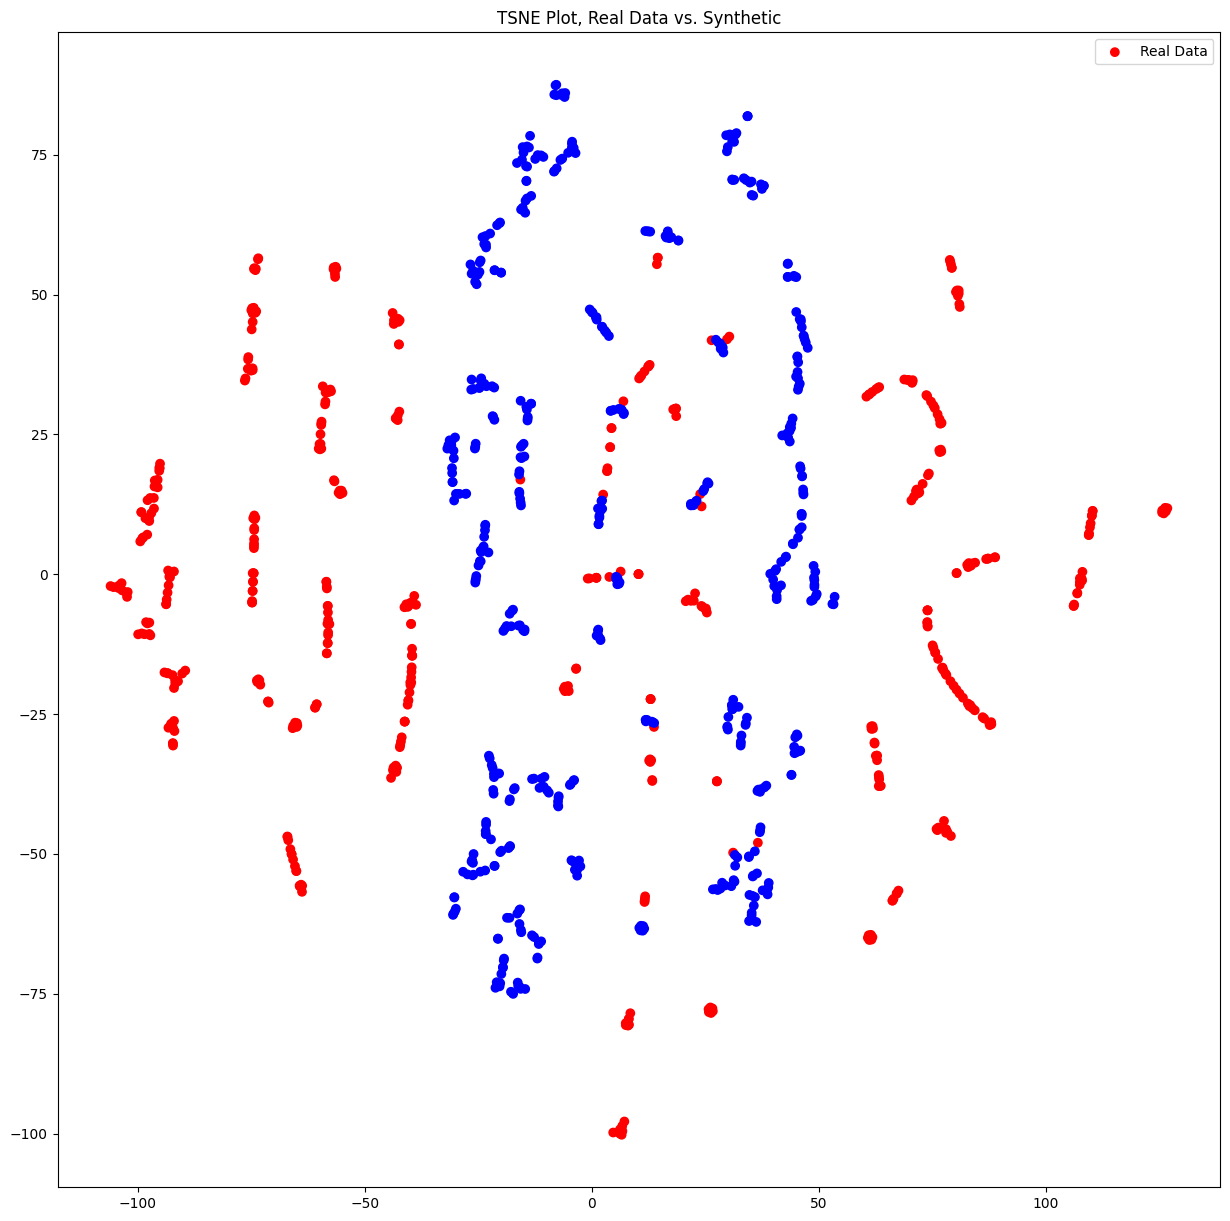

In [13]:
# Call this only if you want to see the TSNE plot
tsne_plot(pums, synthetic)


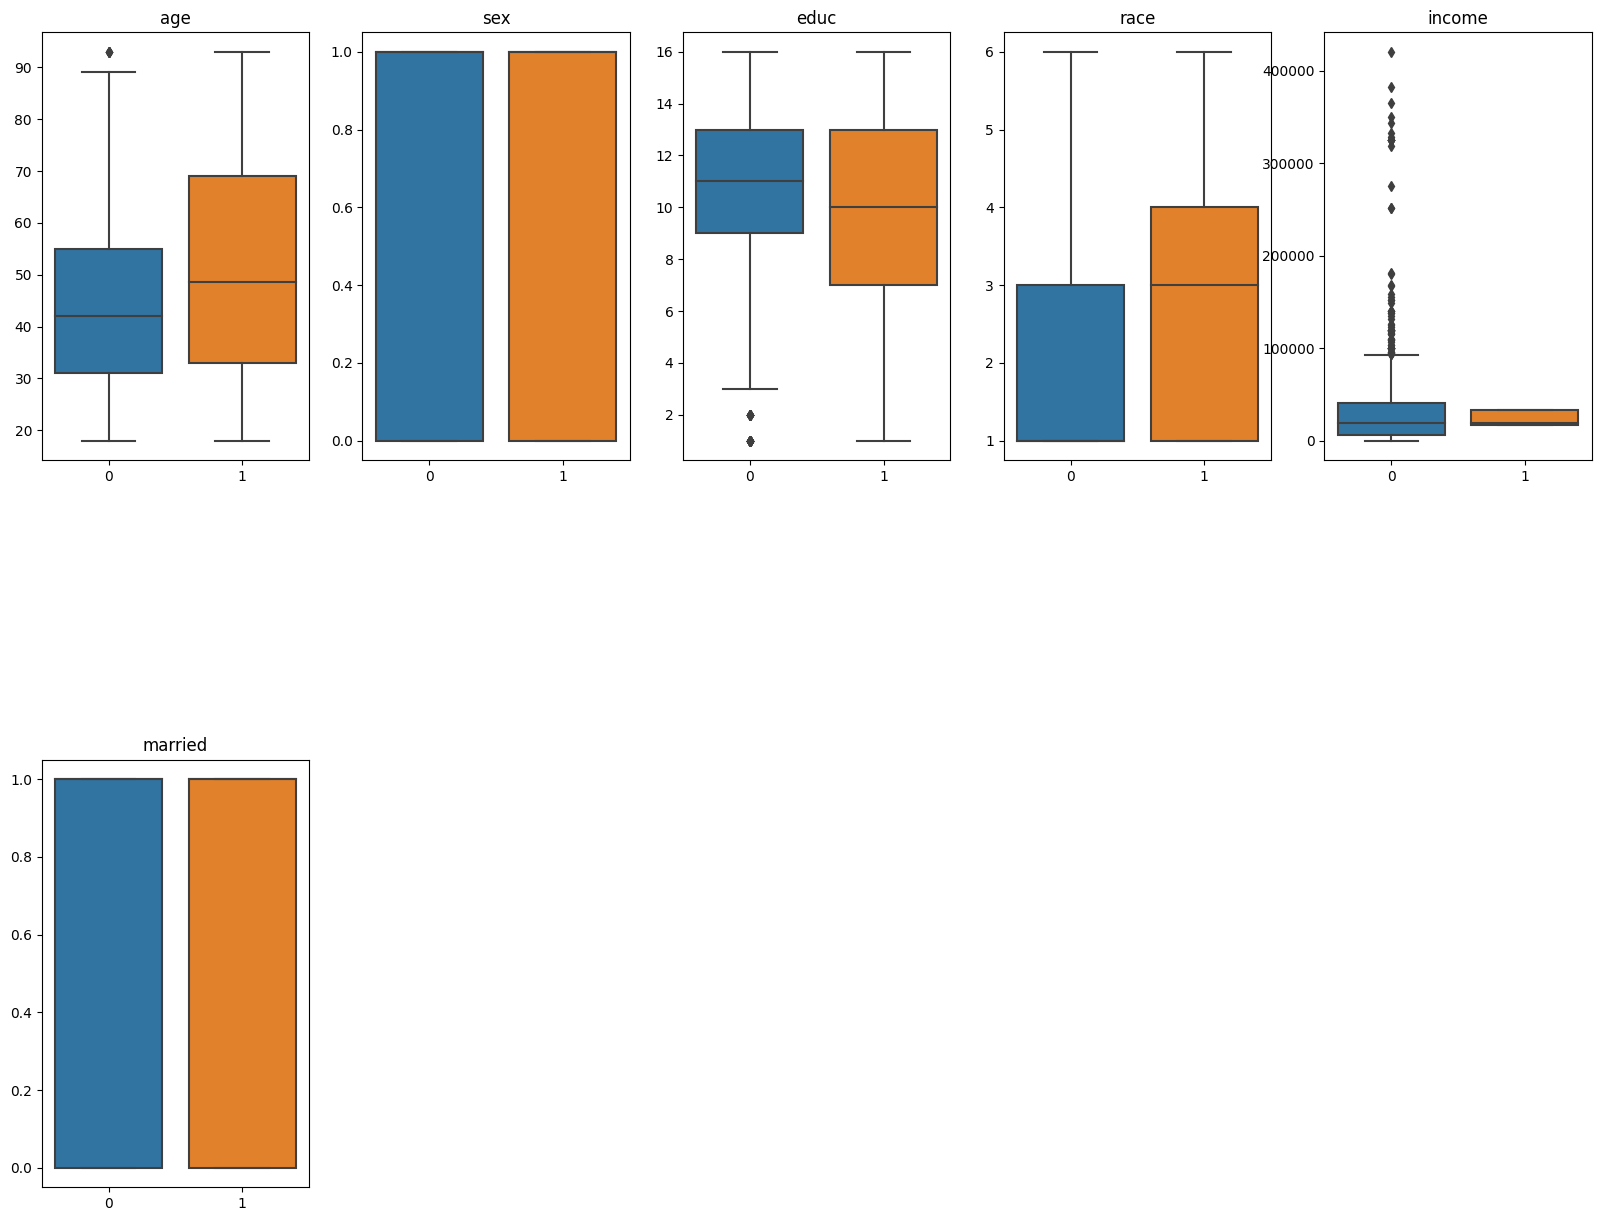

In [14]:
plot_feature_boxplots(pums, synthetic)


In [18]:
test_real_vs_synthetic_data(pums, synthetic, LogisticRegression, describe = True)

               age          sex         educ         race        income  \
count  1000.000000  1000.000000  1000.000000  1000.000000    1000.00000   
mean     44.797000     0.514000     9.888000     1.954000   34380.08400   
std      17.745385     0.500054     3.415424     1.155517   51491.28621   
min      18.000000     0.000000     1.000000     1.000000       0.00000   
25%      31.000000     0.000000     9.000000     1.000000    6500.00000   
50%      42.000000     1.000000    11.000000     1.000000   19150.00000   
75%      55.000000     1.000000    13.000000     3.000000   41075.00000   
max      93.000000     1.000000    16.000000     6.000000  420500.00000   

           married  
count  1000.000000  
mean      0.549000  
std       0.497842  
min       0.000000  
25%       0.000000  
50%       1.000000  
75%       1.000000  
max       1.000000  
              age          sex         educ         race        income  \
count  1000.00000  1000.000000  1000.000000  1000.000000   10

(LogisticRegression(), LogisticRegression())

# **Using the MST Method**

- The acronym `MST` stands for **“Maximum-Spanning-Tree”** as the method produces differentially private synthetic data by relying on a “Maximum-Spanning-Tree" of mutual information.

- `MST` finds the maximum spanning tree on a graph where nodes are data attributes and edge weights correspond to approximate mutual information between any two attributes.

- We say approximate here, because the “maximum spanning tree” is built using the exponential mechanism, which helps select edge weights with high levels of mutual information in a differentially private manner. The marginals are measured using the `Gaussian` mechanism.

In [80]:
%%ag

df = pums.drop(["income"], axis=1)
df = df.sample(frac=1, random_state=42)

In [86]:
%%ag
mst_synth = Synthesizer.create("mst", epsilon=3.0, verbose=True)
sample = mst_synth.fit(df, preprocessor_eps=0.1)

Fitting with 28032 dimensions

Getting cliques

Estimating marginals



In [87]:
%%ag
sample_size = len(df)
synth_data = mst_synth.sample(sample_size)

In [90]:
%%ag
# import utils
export(synth_data, 'synth_data')
export(df, 'df')

Setting up exported variable in local environment: synth_data
Setting up exported variable in local environment: df


In [104]:
print(df.describe())
print(synth_data.describe())

               age          sex         educ         race      married
count  1000.000000  1000.000000  1000.000000  1000.000000  1000.000000
mean     44.797000     0.514000     9.888000     1.954000     0.549000
std      17.745385     0.500054     3.415424     1.155517     0.497842
min      18.000000     0.000000     1.000000     1.000000     0.000000
25%      31.000000     0.000000     9.000000     1.000000     0.000000
50%      42.000000     1.000000    11.000000     1.000000     1.000000
75%      55.000000     1.000000    13.000000     3.000000     1.000000
max      93.000000     1.000000    16.000000     6.000000     1.000000
               age          sex         educ         race      married
count  1000.000000  1000.000000  1000.000000  1000.000000  1000.000000
mean     50.179000     0.506000     9.930000     1.929000     0.542000
std      20.674051     0.500214     3.624671     1.135451     0.498482
min      18.000000     0.000000     1.000000     1.000000     0.000000
25%   